# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instructions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Import libraries

In [66]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))
tf.test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow Version 1.12.0


<module 'tensorflow._api.v1.test' from 'C:\\Users\\Anuri\\Desktop\\CS599_1\\lib\\site-packages\\tensorflow\\_api\\v1\\test\\__init__.py'>

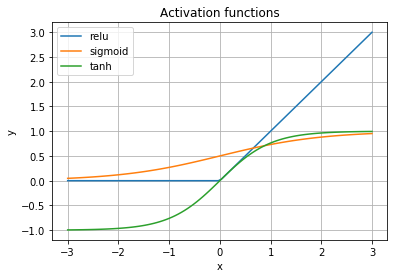

In [67]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [68]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.12.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use the standard 50,000 images for training and 10,000 images for test.

In [5]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )


## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [69]:
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    return tf.layers.flatten(input)

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    return tf.layers.dense(input, units=num_output)
    

def norm(input, training):
    """
        - input: input tensors
        - is_training: boolean, if during training or not
    """
    #return tf.nn.local_response_normalization(input)
    return tf.layers.batch_normalization(input, training = training)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional neural network

In [72]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3,2)
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        with tf.variable_scope('flatten'):
            self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 =  fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 5e-4
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op)
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: epoch, Y: training loss
            plt.subplot(211)
            plt.ylabel('Training Loss')
            plt.xlabel('Epoch')
            plt.plot(range(len(losses)), losses, label='Training Loss')
            plt.show()
        
        # Graph 2. X: epoch, Y: accuracy
            plt.subplot(212)
            plt.ylabel('Training Accuracy')
            plt.xlabel('Iteration')
            plt.plot(range(len(accuracies)), accuracies, label='Training Accuracy')
            plt.show()
        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X : X_, self.Y : Y_}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.319, accuracy = 0.109
iteration (50): loss = 1.569, accuracy = 0.469
iteration (100): loss = 1.423, accuracy = 0.477
iteration (150): loss = 1.339, accuracy = 0.523
iteration (200): loss = 1.397, accuracy = 0.539
iteration (250): loss = 1.261, accuracy = 0.586
iteration (300): loss = 1.136, accuracy = 0.625
iteration (350): loss = 1.185, accuracy = 0.594
validation for epoch 0
-  epoch 0: validation accuracy = 0.635


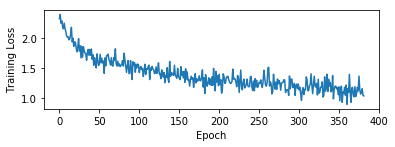

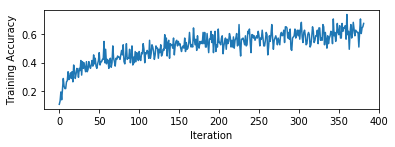

train for epoch 1
iteration (400): loss = 0.930, accuracy = 0.680
iteration (450): loss = 1.116, accuracy = 0.570
iteration (500): loss = 0.941, accuracy = 0.641
iteration (550): loss = 0.859, accuracy = 0.688
iteration (600): loss = 0.892, accuracy = 0.711
iteration (650): loss = 1.009, accuracy = 0.633
iteration (700): loss = 0.961, accuracy = 0.672
iteration (750): loss = 0.790, accuracy = 0.758
validation for epoch 1
-  epoch 1: validation accuracy = 0.676


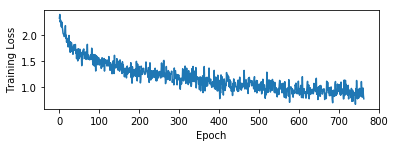

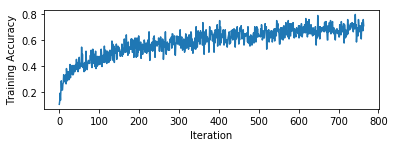

train for epoch 2
iteration (800): loss = 0.741, accuracy = 0.734
iteration (850): loss = 0.933, accuracy = 0.672
iteration (900): loss = 0.736, accuracy = 0.727
iteration (950): loss = 0.684, accuracy = 0.773
iteration (1000): loss = 0.619, accuracy = 0.812
iteration (1050): loss = 0.769, accuracy = 0.750
iteration (1100): loss = 0.712, accuracy = 0.773
validation for epoch 2
-  epoch 2: validation accuracy = 0.711


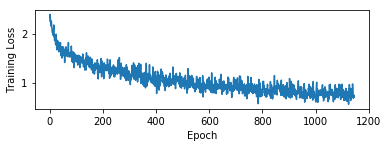

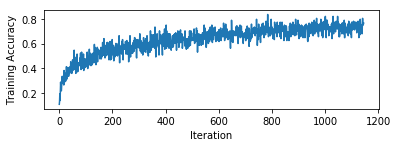

train for epoch 3
iteration (1150): loss = 0.798, accuracy = 0.719
iteration (1200): loss = 0.706, accuracy = 0.711
iteration (1250): loss = 0.786, accuracy = 0.695
iteration (1300): loss = 0.876, accuracy = 0.656
iteration (1350): loss = 0.598, accuracy = 0.867
iteration (1400): loss = 0.689, accuracy = 0.734
iteration (1450): loss = 0.595, accuracy = 0.797
iteration (1500): loss = 0.541, accuracy = 0.781
validation for epoch 3
-  epoch 3: validation accuracy = 0.717


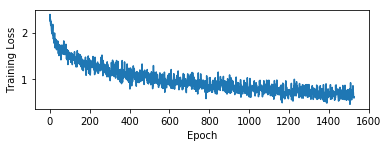

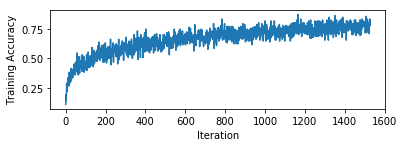

train for epoch 4
iteration (1550): loss = 0.558, accuracy = 0.789
iteration (1600): loss = 0.641, accuracy = 0.781
iteration (1650): loss = 0.717, accuracy = 0.758
iteration (1700): loss = 0.629, accuracy = 0.734
iteration (1750): loss = 0.689, accuracy = 0.773
iteration (1800): loss = 0.537, accuracy = 0.805
iteration (1850): loss = 0.496, accuracy = 0.828
iteration (1900): loss = 0.565, accuracy = 0.812
validation for epoch 4
-  epoch 4: validation accuracy = 0.734


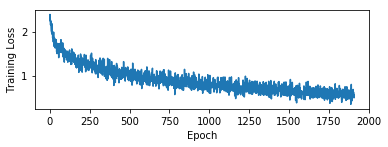

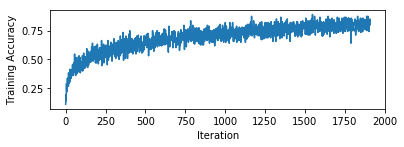

***** test accuracy: 0.711
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [73]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.  
For GPU usage, simply change the following line of the training block:  
from `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')`  
and you can set your desired device number  

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80%, you will get 5 extra points.

In [59]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 60

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################
        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.leaky_relu(self.conv1, alpha=0.01)
            self.norm1 = norm(self.relu1, self.is_Train)
            self.pool1 = max_pool(self.norm1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.leaky_relu(self.conv2, alpha=0.01)
            self.norm2 = norm(self.relu2, self.is_Train)
            self.pool2 = max_pool(self.norm2, 3,2)
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.pool2, 3, 1, 128)
            self.relu3 = tf.nn.leaky_relu(self.conv3, alpha=0.01)
            self.norm3 = norm(self.relu3, self.is_Train)
            self.pool3 = max_pool(self.norm3, 3,2)
            print('conv3 layer: ' + str(self.pool3.get_shape()))

        
        
            
        
        
        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        with tf.variable_scope('flatten'):
            self.flat = flatten(self.pool3)
            print('flat layer: ' + str(self.flat.get_shape()))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 =  fc(self.flat, 256)
            self.dropout4 = tf.layers.dropout(self.fc4, self.keep_prob)
            #self.batch_norm4 = tf.layers.batch_normalization(self.dropout4, training = self.is_Train )
            self.relu4 = tf.nn.relu(self.dropout4)
            
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.relu4.get_shape()))
            
        
        with tf.variable_scope('fc5'):
            self.fc5 = fc(self.relu4, 128)
            self.dropout5 = tf.layers.dropout(self.fc5, self.keep_prob)
            #self.batch_norm5 = tf.layers.batch_normalization(self.dropout5, training = self.is_Train )
            self.relu5 = tf.nn.relu(self.dropout5)
            
            print('fc5 layer: ' + str(self.relu5.get_shape()))
            
            
        
        with tf.variable_scope('fc6'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc6 = fc(self.relu5, 10)
            
            print('fc6 layer: ' + str(self.fc6.get_shape()))
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            
            
        # Return the last layer
        return self.fc6

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_Train = tf.placeholder(tf.bool, name = "is_train")
        self.keep_prob = tf.placeholder(tf.float32)
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 5e-4
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,1000, 0.96, staircase=True)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step=global_step)
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    
        
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_, self.keep_prob : 0.4, self.is_Train : True}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1
            
            
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(211)
            plt.ylabel('Training Loss')
            plt.xlabel('Epoch')
            plt.plot(range(len(losses)), losses, label='Training Loss')
            plt.show()
        
            # Graph 2. X: epoch, Y: accuracy
            plt.subplot(212)
            plt.ylabel('Training Accuracy')
            plt.xlabel('Iterations')
            plt.plot(range(len(accuracies)), accuracies, label='Training Accuracy')
            plt.show()
        
            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X : X_, self.Y : Y_, self.keep_prob : 1.0, self.is_Train : False}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter
        
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

def data_augmentation(X_train, Y_train):
    print (X_train.shape, np.fliplr(X_train).shape)
    trainX = np.concatenate((X_train, np.flip(X_train, axis=2)), axis=0)
    trainY = np.concatenate((Y_train, Y_train), axis=0)
    return (trainX,trainY)
    

    

(49000, 32, 32, 3) (49000, 32, 32, 3)
(98000, 32, 32, 3) (98000,)
-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 128)
flat layer: (?, 2048)
fc4 layer: (?, 256)
fc5 layer: (?, 128)
fc6 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 3.279, accuracy = 0.094
iteration (50): loss = 1.415, accuracy = 0.461
iteration (100): loss = 1.316, accuracy = 0.539
iteration (150): loss = 1.239, accuracy = 0.562
iteration (200): loss = 1.272, accuracy = 0.508
iteration (250): loss = 1.170, accuracy = 0.570
iteration (300): loss = 0.953, accuracy = 0.688
iteration (350): loss = 1.113, accuracy = 0.562


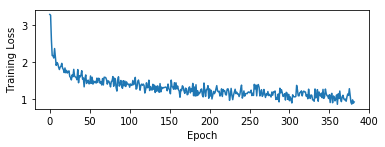

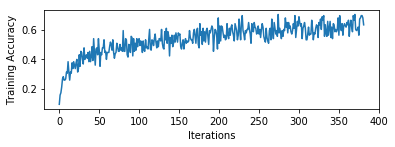

validation for epoch 0
-  epoch 0: validation accuracy = 0.599
train for epoch 1
iteration (400): loss = 0.985, accuracy = 0.586
iteration (450): loss = 0.997, accuracy = 0.633
iteration (500): loss = 0.885, accuracy = 0.703
iteration (550): loss = 0.804, accuracy = 0.742
iteration (600): loss = 0.878, accuracy = 0.688
iteration (650): loss = 1.011, accuracy = 0.633
iteration (700): loss = 0.852, accuracy = 0.695
iteration (750): loss = 0.799, accuracy = 0.742


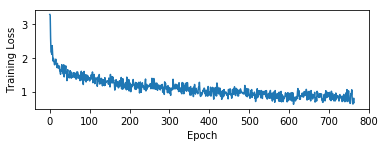

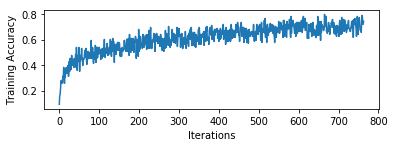

validation for epoch 1
-  epoch 1: validation accuracy = 0.653
train for epoch 2
iteration (800): loss = 0.679, accuracy = 0.758
iteration (850): loss = 0.767, accuracy = 0.734
iteration (900): loss = 0.753, accuracy = 0.742
iteration (950): loss = 0.705, accuracy = 0.742
iteration (1000): loss = 0.617, accuracy = 0.766
iteration (1050): loss = 0.692, accuracy = 0.758
iteration (1100): loss = 0.589, accuracy = 0.797


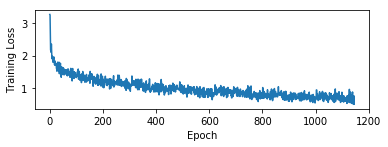

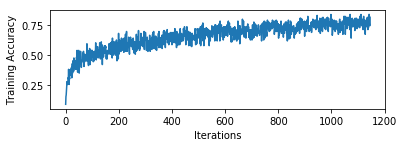

validation for epoch 2
-  epoch 2: validation accuracy = 0.703
train for epoch 3
iteration (1150): loss = 0.662, accuracy = 0.750
iteration (1200): loss = 0.505, accuracy = 0.805
iteration (1250): loss = 0.651, accuracy = 0.789
iteration (1300): loss = 0.745, accuracy = 0.766
iteration (1350): loss = 0.528, accuracy = 0.844
iteration (1400): loss = 0.495, accuracy = 0.836
iteration (1450): loss = 0.484, accuracy = 0.852
iteration (1500): loss = 0.460, accuracy = 0.844


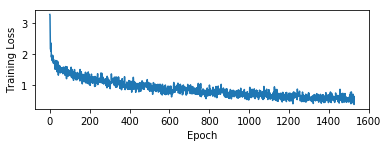

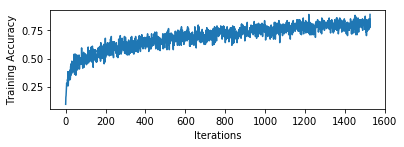

validation for epoch 3
-  epoch 3: validation accuracy = 0.710
train for epoch 4
iteration (1550): loss = 0.377, accuracy = 0.844
iteration (1600): loss = 0.624, accuracy = 0.789
iteration (1650): loss = 0.723, accuracy = 0.789
iteration (1700): loss = 0.447, accuracy = 0.828
iteration (1750): loss = 0.518, accuracy = 0.805
iteration (1800): loss = 0.469, accuracy = 0.836
iteration (1850): loss = 0.415, accuracy = 0.805
iteration (1900): loss = 0.471, accuracy = 0.836


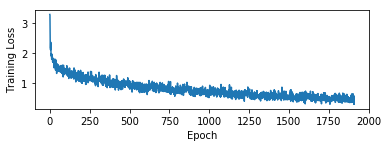

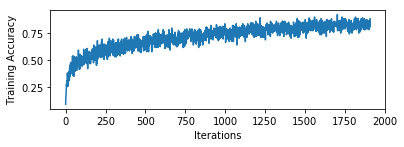

validation for epoch 4
-  epoch 4: validation accuracy = 0.684
train for epoch 5
iteration (1950): loss = 0.509, accuracy = 0.828
iteration (2000): loss = 0.424, accuracy = 0.836
iteration (2050): loss = 0.379, accuracy = 0.883
iteration (2100): loss = 0.514, accuracy = 0.836
iteration (2150): loss = 0.472, accuracy = 0.820
iteration (2200): loss = 0.408, accuracy = 0.867
iteration (2250): loss = 0.397, accuracy = 0.852


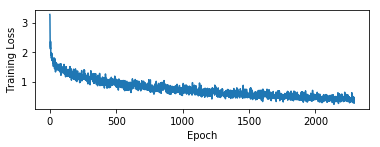

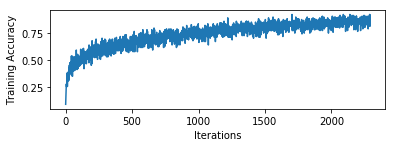

validation for epoch 5
-  epoch 5: validation accuracy = 0.695
train for epoch 6
iteration (2300): loss = 0.449, accuracy = 0.828
iteration (2350): loss = 0.339, accuracy = 0.891
iteration (2400): loss = 0.411, accuracy = 0.906
iteration (2450): loss = 0.347, accuracy = 0.906
iteration (2500): loss = 0.298, accuracy = 0.898
iteration (2550): loss = 0.435, accuracy = 0.859
iteration (2600): loss = 0.371, accuracy = 0.859
iteration (2650): loss = 0.310, accuracy = 0.867


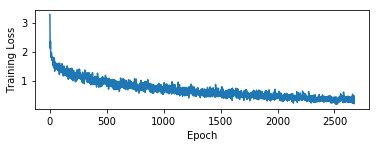

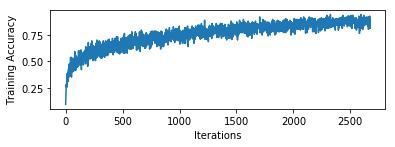

validation for epoch 6
-  epoch 6: validation accuracy = 0.731
train for epoch 7
iteration (2700): loss = 0.369, accuracy = 0.883
iteration (2750): loss = 0.326, accuracy = 0.875
iteration (2800): loss = 0.258, accuracy = 0.898
iteration (2850): loss = 0.181, accuracy = 0.945
iteration (2900): loss = 0.193, accuracy = 0.938
iteration (2950): loss = 0.381, accuracy = 0.836
iteration (3000): loss = 0.281, accuracy = 0.906
iteration (3050): loss = 0.188, accuracy = 0.953


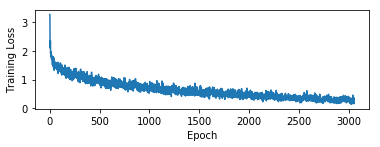

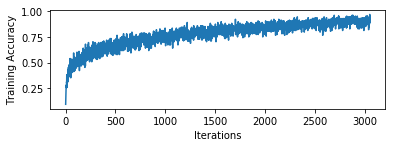

validation for epoch 7
-  epoch 7: validation accuracy = 0.710
train for epoch 8
iteration (3100): loss = 0.458, accuracy = 0.828
iteration (3150): loss = 0.293, accuracy = 0.875
iteration (3200): loss = 0.342, accuracy = 0.883
iteration (3250): loss = 0.245, accuracy = 0.922
iteration (3300): loss = 0.184, accuracy = 0.953
iteration (3350): loss = 0.361, accuracy = 0.844
iteration (3400): loss = 0.219, accuracy = 0.906


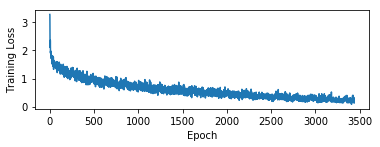

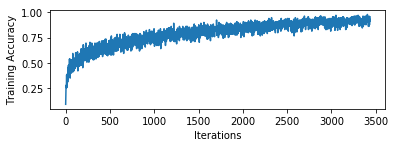

validation for epoch 8
-  epoch 8: validation accuracy = 0.730
train for epoch 9
iteration (3450): loss = 0.185, accuracy = 0.945
iteration (3500): loss = 0.129, accuracy = 0.969
iteration (3550): loss = 0.268, accuracy = 0.883
iteration (3600): loss = 0.116, accuracy = 0.969
iteration (3650): loss = 0.272, accuracy = 0.914
iteration (3700): loss = 0.173, accuracy = 0.945
iteration (3750): loss = 0.113, accuracy = 0.945
iteration (3800): loss = 0.199, accuracy = 0.906


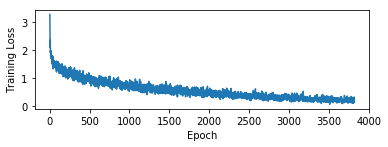

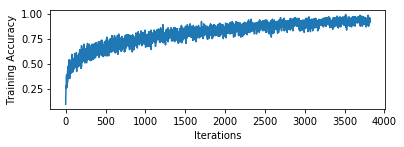

validation for epoch 9
-  epoch 9: validation accuracy = 0.739
train for epoch 10
iteration (3850): loss = 0.127, accuracy = 0.953
iteration (3900): loss = 0.208, accuracy = 0.930
iteration (3950): loss = 0.149, accuracy = 0.945
iteration (4000): loss = 0.126, accuracy = 0.961
iteration (4050): loss = 0.145, accuracy = 0.938
iteration (4100): loss = 0.112, accuracy = 0.961
iteration (4150): loss = 0.109, accuracy = 0.961
iteration (4200): loss = 0.132, accuracy = 0.953


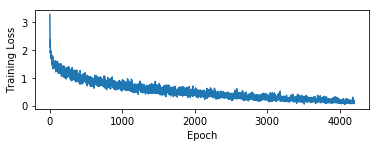

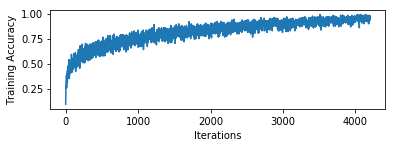

validation for epoch 10
-  epoch 10: validation accuracy = 0.740
train for epoch 11
iteration (4250): loss = 0.082, accuracy = 0.977
iteration (4300): loss = 0.093, accuracy = 0.977
iteration (4350): loss = 0.160, accuracy = 0.922
iteration (4400): loss = 0.125, accuracy = 0.977
iteration (4450): loss = 0.090, accuracy = 0.961
iteration (4500): loss = 0.111, accuracy = 0.953
iteration (4550): loss = 0.098, accuracy = 0.977


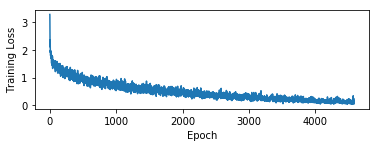

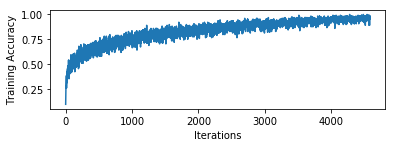

validation for epoch 11
-  epoch 11: validation accuracy = 0.695
train for epoch 12
iteration (4600): loss = 0.063, accuracy = 0.992
iteration (4650): loss = 0.066, accuracy = 0.977
iteration (4700): loss = 0.139, accuracy = 0.938
iteration (4750): loss = 0.155, accuracy = 0.961
iteration (4800): loss = 0.021, accuracy = 1.000
iteration (4850): loss = 0.077, accuracy = 0.984
iteration (4900): loss = 0.124, accuracy = 0.945
iteration (4950): loss = 0.074, accuracy = 0.961


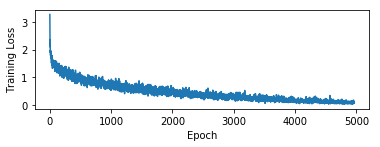

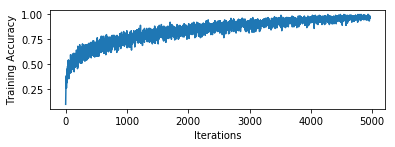

validation for epoch 12
-  epoch 12: validation accuracy = 0.709
train for epoch 13
iteration (5000): loss = 0.100, accuracy = 0.969
iteration (5050): loss = 0.137, accuracy = 0.953
iteration (5100): loss = 0.128, accuracy = 0.961
iteration (5150): loss = 0.041, accuracy = 0.992
iteration (5200): loss = 0.081, accuracy = 0.969
iteration (5250): loss = 0.099, accuracy = 0.953
iteration (5300): loss = 0.076, accuracy = 0.984


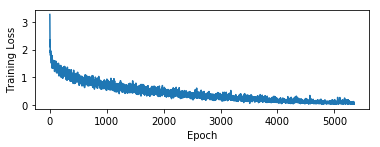

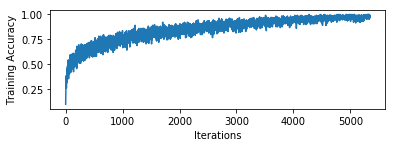

validation for epoch 13
-  epoch 13: validation accuracy = 0.754
train for epoch 14
iteration (5350): loss = 0.085, accuracy = 0.961
iteration (5400): loss = 0.112, accuracy = 0.961
iteration (5450): loss = 0.090, accuracy = 0.977
iteration (5500): loss = 0.046, accuracy = 0.984
iteration (5550): loss = 0.096, accuracy = 0.969
iteration (5600): loss = 0.046, accuracy = 0.984
iteration (5650): loss = 0.055, accuracy = 0.977
iteration (5700): loss = 0.050, accuracy = 0.977


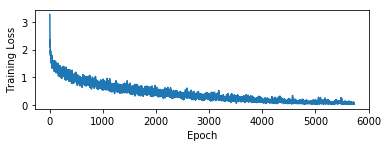

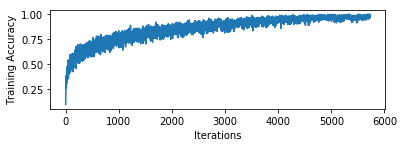

validation for epoch 14
-  epoch 14: validation accuracy = 0.770
train for epoch 15
iteration (5750): loss = 0.045, accuracy = 0.992
iteration (5800): loss = 0.100, accuracy = 0.977
iteration (5850): loss = 0.089, accuracy = 0.953
iteration (5900): loss = 0.109, accuracy = 0.961
iteration (5950): loss = 0.056, accuracy = 0.984
iteration (6000): loss = 0.081, accuracy = 0.969
iteration (6050): loss = 0.056, accuracy = 0.977
iteration (6100): loss = 0.060, accuracy = 0.984


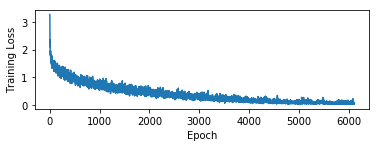

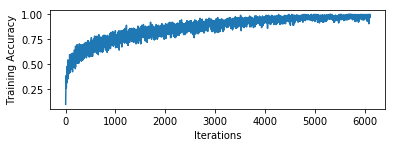

validation for epoch 15
-  epoch 15: validation accuracy = 0.728
train for epoch 16
iteration (6150): loss = 0.092, accuracy = 0.969
iteration (6200): loss = 0.079, accuracy = 0.984
iteration (6250): loss = 0.060, accuracy = 0.992
iteration (6300): loss = 0.076, accuracy = 0.977
iteration (6350): loss = 0.023, accuracy = 0.992
iteration (6400): loss = 0.040, accuracy = 0.984
iteration (6450): loss = 0.054, accuracy = 0.977


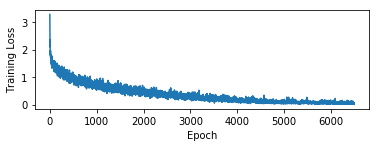

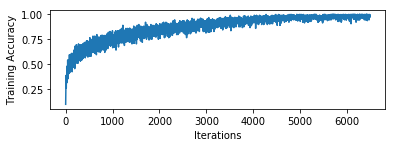

validation for epoch 16
-  epoch 16: validation accuracy = 0.772
train for epoch 17
iteration (6500): loss = 0.073, accuracy = 0.969
iteration (6550): loss = 0.092, accuracy = 0.969
iteration (6600): loss = 0.075, accuracy = 0.977
iteration (6650): loss = 0.030, accuracy = 0.984
iteration (6700): loss = 0.024, accuracy = 0.992
iteration (6750): loss = 0.028, accuracy = 1.000
iteration (6800): loss = 0.087, accuracy = 0.953
iteration (6850): loss = 0.042, accuracy = 0.977


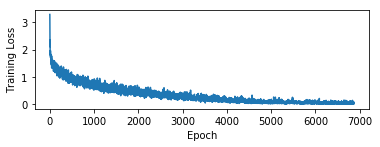

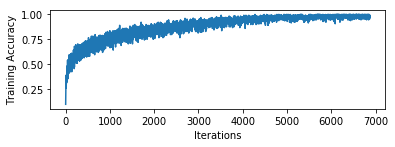

validation for epoch 17
-  epoch 17: validation accuracy = 0.763
train for epoch 18
iteration (6900): loss = 0.046, accuracy = 0.984
iteration (6950): loss = 0.013, accuracy = 1.000
iteration (7000): loss = 0.142, accuracy = 0.945
iteration (7050): loss = 0.031, accuracy = 1.000
iteration (7100): loss = 0.017, accuracy = 1.000
iteration (7150): loss = 0.063, accuracy = 0.984
iteration (7200): loss = 0.055, accuracy = 0.992
iteration (7250): loss = 0.066, accuracy = 0.969


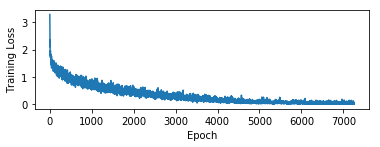

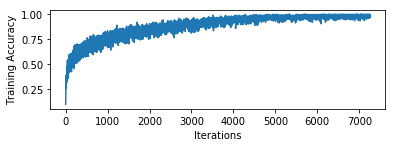

validation for epoch 18
-  epoch 18: validation accuracy = 0.772
train for epoch 19
iteration (7300): loss = 0.034, accuracy = 0.977
iteration (7350): loss = 0.047, accuracy = 0.984
iteration (7400): loss = 0.041, accuracy = 0.984
iteration (7450): loss = 0.038, accuracy = 0.984
iteration (7500): loss = 0.046, accuracy = 0.984
iteration (7550): loss = 0.067, accuracy = 0.969
iteration (7600): loss = 0.043, accuracy = 0.969


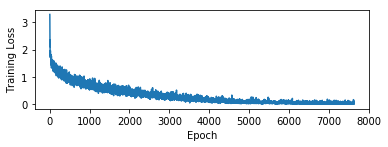

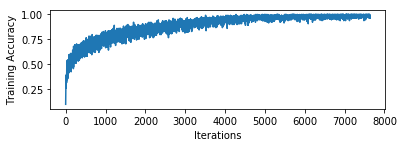

validation for epoch 19
-  epoch 19: validation accuracy = 0.765
train for epoch 20
iteration (7650): loss = 0.067, accuracy = 0.969
iteration (7700): loss = 0.065, accuracy = 0.977
iteration (7750): loss = 0.010, accuracy = 1.000
iteration (7800): loss = 0.054, accuracy = 0.977
iteration (7850): loss = 0.014, accuracy = 1.000
iteration (7900): loss = 0.082, accuracy = 0.961
iteration (7950): loss = 0.061, accuracy = 0.984
iteration (8000): loss = 0.044, accuracy = 0.992


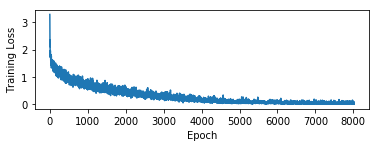

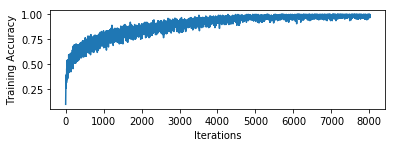

validation for epoch 20
-  epoch 20: validation accuracy = 0.746
train for epoch 21
iteration (8050): loss = 0.023, accuracy = 0.984
iteration (8100): loss = 0.022, accuracy = 0.984
iteration (8150): loss = 0.025, accuracy = 0.992
iteration (8200): loss = 0.016, accuracy = 1.000
iteration (8250): loss = 0.028, accuracy = 0.984
iteration (8300): loss = 0.013, accuracy = 1.000
iteration (8350): loss = 0.023, accuracy = 1.000
iteration (8400): loss = 0.010, accuracy = 1.000


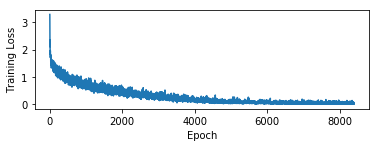

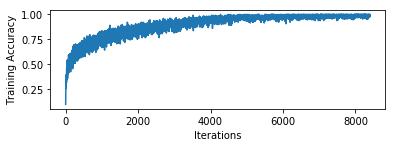

validation for epoch 21
-  epoch 21: validation accuracy = 0.743
train for epoch 22
iteration (8450): loss = 0.028, accuracy = 0.984
iteration (8500): loss = 0.018, accuracy = 1.000
iteration (8550): loss = 0.046, accuracy = 0.984
iteration (8600): loss = 0.027, accuracy = 0.992
iteration (8650): loss = 0.059, accuracy = 0.977
iteration (8700): loss = 0.030, accuracy = 0.984
iteration (8750): loss = 0.045, accuracy = 0.977


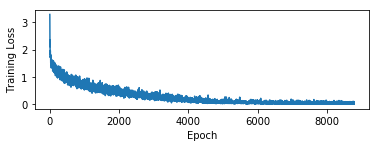

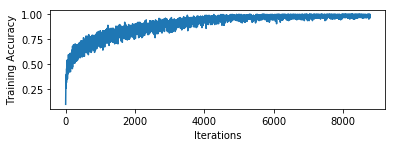

validation for epoch 22
-  epoch 22: validation accuracy = 0.750
train for epoch 23
iteration (8800): loss = 0.011, accuracy = 0.992
iteration (8850): loss = 0.027, accuracy = 0.992
iteration (8900): loss = 0.038, accuracy = 0.984
iteration (8950): loss = 0.008, accuracy = 1.000
iteration (9000): loss = 0.016, accuracy = 1.000
iteration (9050): loss = 0.036, accuracy = 0.992
iteration (9100): loss = 0.009, accuracy = 1.000
iteration (9150): loss = 0.023, accuracy = 0.992


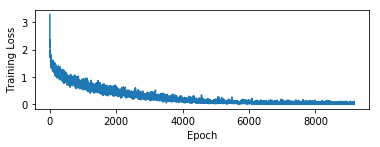

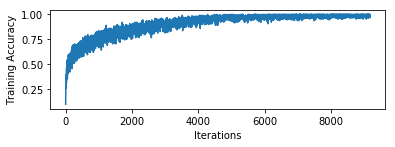

validation for epoch 23
-  epoch 23: validation accuracy = 0.773
train for epoch 24
iteration (9200): loss = 0.051, accuracy = 0.984
iteration (9250): loss = 0.015, accuracy = 1.000
iteration (9300): loss = 0.015, accuracy = 1.000
iteration (9350): loss = 0.015, accuracy = 1.000
iteration (9400): loss = 0.014, accuracy = 0.992
iteration (9450): loss = 0.011, accuracy = 1.000
iteration (9500): loss = 0.093, accuracy = 0.953


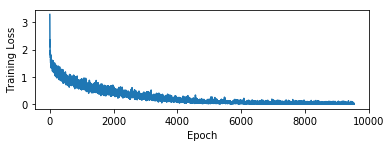

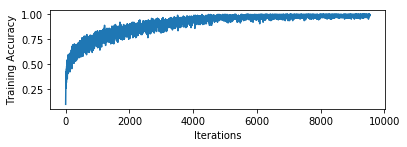

validation for epoch 24
-  epoch 24: validation accuracy = 0.779
train for epoch 25
iteration (9550): loss = 0.004, accuracy = 1.000
iteration (9600): loss = 0.031, accuracy = 0.992
iteration (9650): loss = 0.022, accuracy = 0.992
iteration (9700): loss = 0.016, accuracy = 0.984
iteration (9750): loss = 0.025, accuracy = 0.992
iteration (9800): loss = 0.035, accuracy = 0.992
iteration (9850): loss = 0.014, accuracy = 1.000
iteration (9900): loss = 0.011, accuracy = 0.992


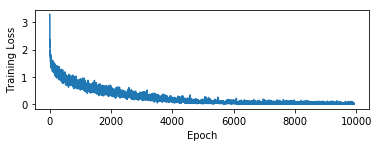

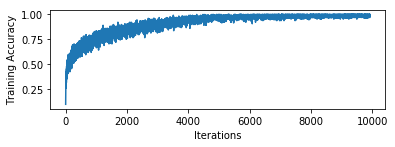

validation for epoch 25
-  epoch 25: validation accuracy = 0.763
train for epoch 26
iteration (9950): loss = 0.009, accuracy = 1.000
iteration (10000): loss = 0.023, accuracy = 0.992
iteration (10050): loss = 0.017, accuracy = 0.992
iteration (10100): loss = 0.010, accuracy = 1.000
iteration (10150): loss = 0.016, accuracy = 0.992
iteration (10200): loss = 0.006, accuracy = 1.000
iteration (10250): loss = 0.010, accuracy = 0.992
iteration (10300): loss = 0.034, accuracy = 0.992


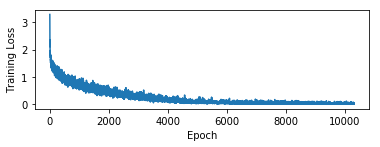

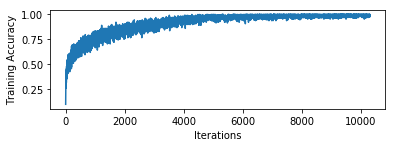

validation for epoch 26
-  epoch 26: validation accuracy = 0.771
train for epoch 27
iteration (10350): loss = 0.012, accuracy = 0.992
iteration (10400): loss = 0.056, accuracy = 0.977
iteration (10450): loss = 0.024, accuracy = 0.992
iteration (10500): loss = 0.034, accuracy = 0.984
iteration (10550): loss = 0.001, accuracy = 1.000
iteration (10600): loss = 0.004, accuracy = 1.000
iteration (10650): loss = 0.009, accuracy = 0.992


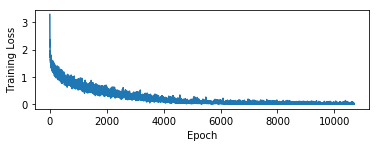

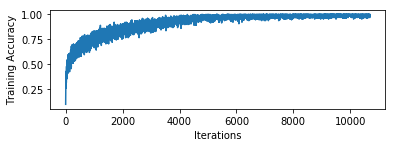

validation for epoch 27
-  epoch 27: validation accuracy = 0.766
train for epoch 28
iteration (10700): loss = 0.007, accuracy = 1.000
iteration (10750): loss = 0.015, accuracy = 0.992
iteration (10800): loss = 0.013, accuracy = 0.992
iteration (10850): loss = 0.037, accuracy = 0.992
iteration (10900): loss = 0.011, accuracy = 1.000
iteration (10950): loss = 0.005, accuracy = 1.000
iteration (11000): loss = 0.012, accuracy = 1.000
iteration (11050): loss = 0.004, accuracy = 1.000


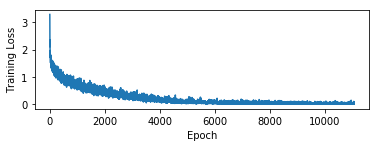

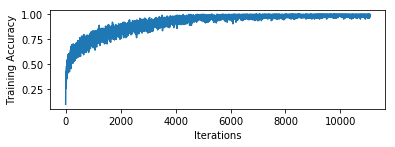

validation for epoch 28
-  epoch 28: validation accuracy = 0.747
train for epoch 29
iteration (11100): loss = 0.015, accuracy = 0.992
iteration (11150): loss = 0.018, accuracy = 0.992
iteration (11200): loss = 0.017, accuracy = 0.992
iteration (11250): loss = 0.010, accuracy = 0.992
iteration (11300): loss = 0.016, accuracy = 1.000
iteration (11350): loss = 0.001, accuracy = 1.000
iteration (11400): loss = 0.002, accuracy = 1.000
iteration (11450): loss = 0.025, accuracy = 0.992


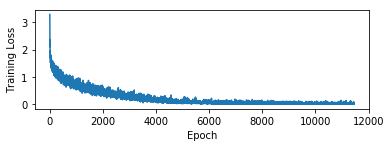

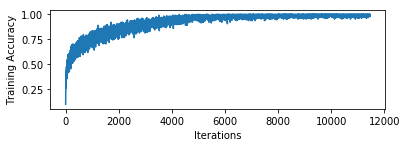

validation for epoch 29
-  epoch 29: validation accuracy = 0.781
train for epoch 30
iteration (11500): loss = 0.016, accuracy = 1.000
iteration (11550): loss = 0.017, accuracy = 0.992
iteration (11600): loss = 0.007, accuracy = 1.000
iteration (11650): loss = 0.044, accuracy = 0.977
iteration (11700): loss = 0.006, accuracy = 1.000
iteration (11750): loss = 0.018, accuracy = 0.992
iteration (11800): loss = 0.003, accuracy = 1.000


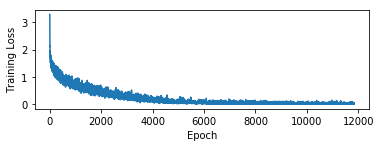

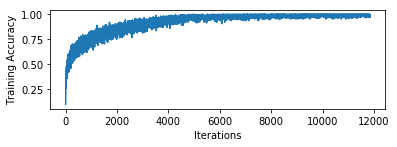

validation for epoch 30
-  epoch 30: validation accuracy = 0.775
train for epoch 31
iteration (11850): loss = 0.022, accuracy = 0.992
iteration (11900): loss = 0.019, accuracy = 0.992
iteration (11950): loss = 0.036, accuracy = 0.984
iteration (12000): loss = 0.010, accuracy = 1.000
iteration (12050): loss = 0.022, accuracy = 0.992
iteration (12100): loss = 0.010, accuracy = 1.000
iteration (12150): loss = 0.006, accuracy = 1.000
iteration (12200): loss = 0.015, accuracy = 0.992


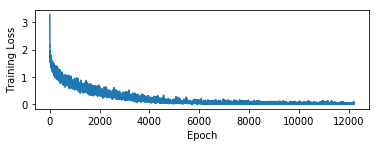

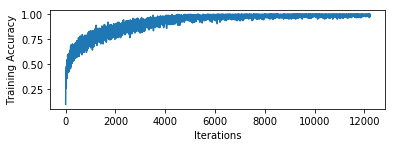

validation for epoch 31
-  epoch 31: validation accuracy = 0.787
train for epoch 32
iteration (12250): loss = 0.019, accuracy = 0.992
iteration (12300): loss = 0.036, accuracy = 0.984
iteration (12350): loss = 0.002, accuracy = 1.000
iteration (12400): loss = 0.058, accuracy = 0.992
iteration (12450): loss = 0.004, accuracy = 1.000
iteration (12500): loss = 0.003, accuracy = 1.000
iteration (12550): loss = 0.004, accuracy = 1.000
iteration (12600): loss = 0.063, accuracy = 0.984


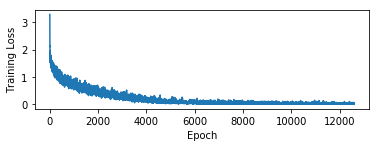

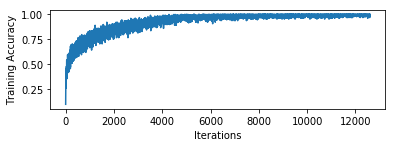

validation for epoch 32
-  epoch 32: validation accuracy = 0.769
train for epoch 33
iteration (12650): loss = 0.008, accuracy = 1.000
iteration (12700): loss = 0.007, accuracy = 1.000
iteration (12750): loss = 0.010, accuracy = 0.992
iteration (12800): loss = 0.014, accuracy = 1.000
iteration (12850): loss = 0.003, accuracy = 1.000
iteration (12900): loss = 0.012, accuracy = 1.000
iteration (12950): loss = 0.028, accuracy = 0.984


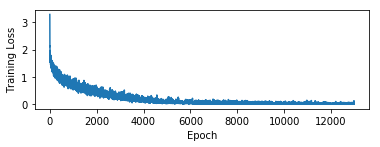

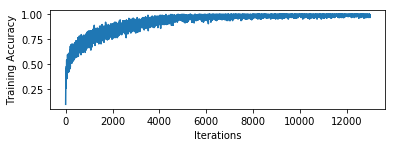

validation for epoch 33
-  epoch 33: validation accuracy = 0.756
train for epoch 34
iteration (13000): loss = 0.042, accuracy = 0.977
iteration (13050): loss = 0.045, accuracy = 0.977
iteration (13100): loss = 0.051, accuracy = 0.977
iteration (13150): loss = 0.012, accuracy = 1.000
iteration (13200): loss = 0.004, accuracy = 1.000
iteration (13250): loss = 0.027, accuracy = 0.984
iteration (13300): loss = 0.004, accuracy = 1.000
iteration (13350): loss = 0.040, accuracy = 0.992


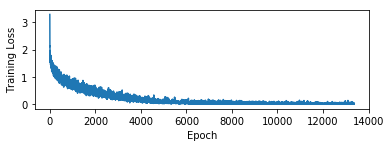

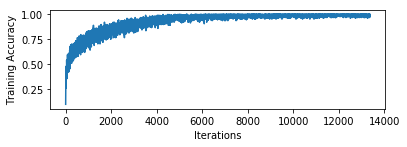

validation for epoch 34
-  epoch 34: validation accuracy = 0.772
train for epoch 35
iteration (13400): loss = 0.008, accuracy = 1.000
iteration (13450): loss = 0.031, accuracy = 0.992
iteration (13500): loss = 0.012, accuracy = 0.992
iteration (13550): loss = 0.002, accuracy = 1.000
iteration (13600): loss = 0.019, accuracy = 0.992
iteration (13650): loss = 0.006, accuracy = 1.000
iteration (13700): loss = 0.009, accuracy = 1.000
iteration (13750): loss = 0.002, accuracy = 1.000


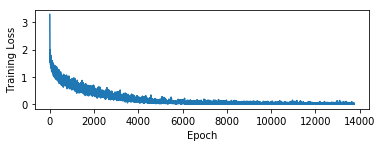

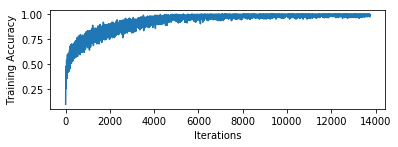

validation for epoch 35
-  epoch 35: validation accuracy = 0.761
train for epoch 36
iteration (13800): loss = 0.004, accuracy = 1.000
iteration (13850): loss = 0.026, accuracy = 0.984
iteration (13900): loss = 0.001, accuracy = 1.000
iteration (13950): loss = 0.010, accuracy = 1.000
iteration (14000): loss = 0.021, accuracy = 0.992
iteration (14050): loss = 0.003, accuracy = 1.000
iteration (14100): loss = 0.011, accuracy = 0.992


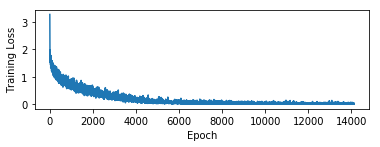

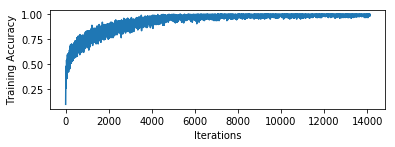

validation for epoch 36
-  epoch 36: validation accuracy = 0.780
train for epoch 37
iteration (14150): loss = 0.010, accuracy = 0.992
iteration (14200): loss = 0.004, accuracy = 1.000
iteration (14250): loss = 0.035, accuracy = 0.984
iteration (14300): loss = 0.002, accuracy = 1.000
iteration (14350): loss = 0.003, accuracy = 1.000
iteration (14400): loss = 0.001, accuracy = 1.000
iteration (14450): loss = 0.053, accuracy = 0.977
iteration (14500): loss = 0.001, accuracy = 1.000


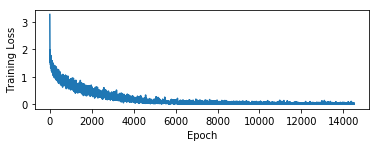

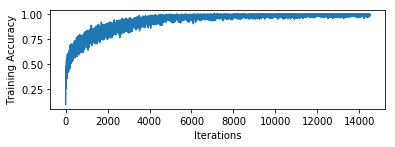

validation for epoch 37
-  epoch 37: validation accuracy = 0.776
train for epoch 38
iteration (14550): loss = 0.001, accuracy = 1.000
iteration (14600): loss = 0.006, accuracy = 1.000
iteration (14650): loss = 0.012, accuracy = 0.992
iteration (14700): loss = 0.017, accuracy = 0.992
iteration (14750): loss = 0.002, accuracy = 1.000
iteration (14800): loss = 0.002, accuracy = 1.000
iteration (14850): loss = 0.008, accuracy = 1.000


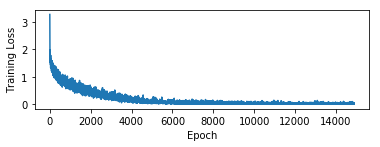

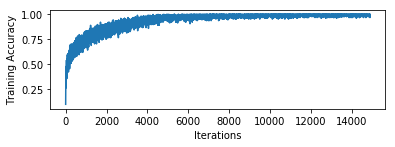

validation for epoch 38
-  epoch 38: validation accuracy = 0.780
train for epoch 39
iteration (14900): loss = 0.009, accuracy = 1.000
iteration (14950): loss = 0.022, accuracy = 0.984
iteration (15000): loss = 0.003, accuracy = 1.000
iteration (15050): loss = 0.029, accuracy = 0.992
iteration (15100): loss = 0.005, accuracy = 1.000
iteration (15150): loss = 0.004, accuracy = 1.000
iteration (15200): loss = 0.002, accuracy = 1.000
iteration (15250): loss = 0.020, accuracy = 0.984


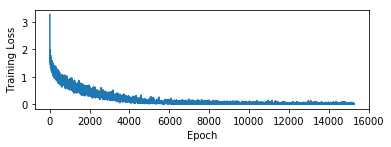

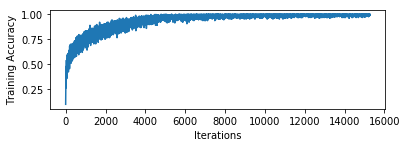

validation for epoch 39
-  epoch 39: validation accuracy = 0.771
train for epoch 40
iteration (15300): loss = 0.001, accuracy = 1.000
iteration (15350): loss = 0.018, accuracy = 0.992
iteration (15400): loss = 0.008, accuracy = 1.000
iteration (15450): loss = 0.001, accuracy = 1.000
iteration (15500): loss = 0.010, accuracy = 1.000
iteration (15550): loss = 0.002, accuracy = 1.000
iteration (15600): loss = 0.030, accuracy = 0.992
iteration (15650): loss = 0.003, accuracy = 1.000


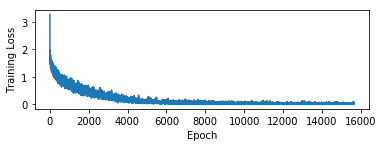

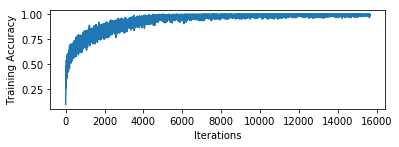

validation for epoch 40
-  epoch 40: validation accuracy = 0.772
train for epoch 41
iteration (15700): loss = 0.043, accuracy = 0.984
iteration (15750): loss = 0.012, accuracy = 0.992
iteration (15800): loss = 0.001, accuracy = 1.000
iteration (15850): loss = 0.004, accuracy = 1.000
iteration (15900): loss = 0.001, accuracy = 1.000
iteration (15950): loss = 0.004, accuracy = 1.000
iteration (16000): loss = 0.001, accuracy = 1.000


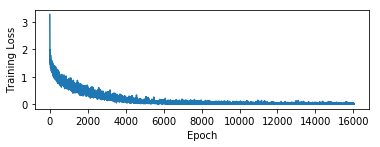

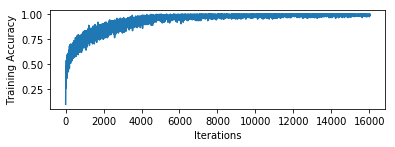

validation for epoch 41
-  epoch 41: validation accuracy = 0.785
train for epoch 42
iteration (16050): loss = 0.001, accuracy = 1.000
iteration (16100): loss = 0.004, accuracy = 1.000
iteration (16150): loss = 0.001, accuracy = 1.000
iteration (16200): loss = 0.007, accuracy = 1.000
iteration (16250): loss = 0.003, accuracy = 1.000
iteration (16300): loss = 0.034, accuracy = 0.984
iteration (16350): loss = 0.006, accuracy = 1.000
iteration (16400): loss = 0.001, accuracy = 1.000


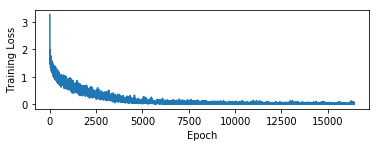

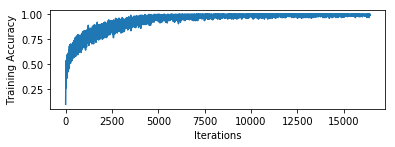

validation for epoch 42
-  epoch 42: validation accuracy = 0.776
train for epoch 43
iteration (16450): loss = 0.003, accuracy = 1.000
iteration (16500): loss = 0.017, accuracy = 0.992
iteration (16550): loss = 0.006, accuracy = 1.000
iteration (16600): loss = 0.048, accuracy = 0.977
iteration (16650): loss = 0.004, accuracy = 1.000
iteration (16700): loss = 0.003, accuracy = 1.000
iteration (16750): loss = 0.008, accuracy = 1.000
iteration (16800): loss = 0.029, accuracy = 0.992


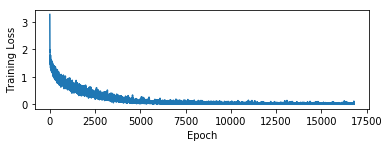

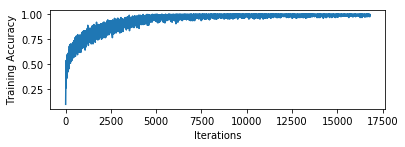

validation for epoch 43
-  epoch 43: validation accuracy = 0.788
train for epoch 44
iteration (16850): loss = 0.004, accuracy = 1.000
iteration (16900): loss = 0.023, accuracy = 0.984
iteration (16950): loss = 0.004, accuracy = 1.000
iteration (17000): loss = 0.010, accuracy = 0.992
iteration (17050): loss = 0.009, accuracy = 1.000
iteration (17100): loss = 0.032, accuracy = 0.984
iteration (17150): loss = 0.009, accuracy = 0.992


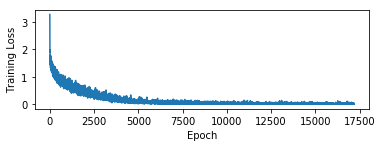

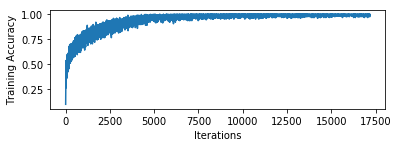

validation for epoch 44
-  epoch 44: validation accuracy = 0.771
train for epoch 45
iteration (17200): loss = 0.007, accuracy = 0.992
iteration (17250): loss = 0.004, accuracy = 1.000
iteration (17300): loss = 0.004, accuracy = 1.000
iteration (17350): loss = 0.004, accuracy = 1.000
iteration (17400): loss = 0.001, accuracy = 1.000
iteration (17450): loss = 0.006, accuracy = 1.000
iteration (17500): loss = 0.019, accuracy = 0.992
iteration (17550): loss = 0.001, accuracy = 1.000


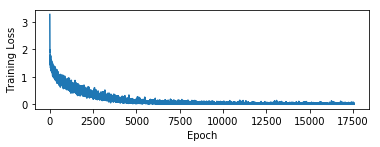

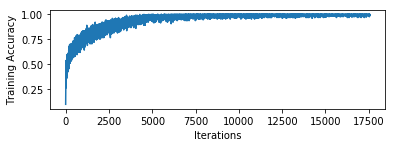

validation for epoch 45
-  epoch 45: validation accuracy = 0.768
train for epoch 46
iteration (17600): loss = 0.015, accuracy = 0.992
iteration (17650): loss = 0.001, accuracy = 1.000
iteration (17700): loss = 0.012, accuracy = 1.000
iteration (17750): loss = 0.009, accuracy = 1.000
iteration (17800): loss = 0.003, accuracy = 1.000
iteration (17850): loss = 0.002, accuracy = 1.000
iteration (17900): loss = 0.001, accuracy = 1.000
iteration (17950): loss = 0.003, accuracy = 1.000


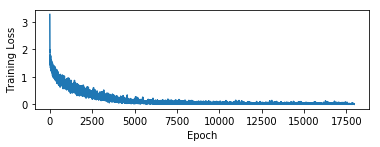

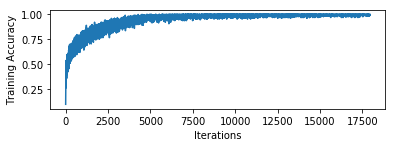

validation for epoch 46
-  epoch 46: validation accuracy = 0.778
train for epoch 47
iteration (18000): loss = 0.001, accuracy = 1.000
iteration (18050): loss = 0.006, accuracy = 1.000
iteration (18100): loss = 0.003, accuracy = 1.000
iteration (18150): loss = 0.004, accuracy = 1.000
iteration (18200): loss = 0.002, accuracy = 1.000
iteration (18250): loss = 0.001, accuracy = 1.000
iteration (18300): loss = 0.002, accuracy = 1.000


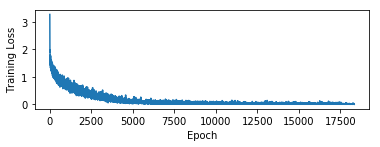

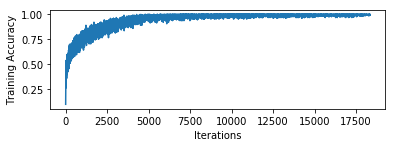

validation for epoch 47
-  epoch 47: validation accuracy = 0.790
train for epoch 48
iteration (18350): loss = 0.003, accuracy = 1.000
iteration (18400): loss = 0.000, accuracy = 1.000
iteration (18450): loss = 0.001, accuracy = 1.000
iteration (18500): loss = 0.020, accuracy = 0.992
iteration (18550): loss = 0.002, accuracy = 1.000
iteration (18600): loss = 0.001, accuracy = 1.000
iteration (18650): loss = 0.001, accuracy = 1.000
iteration (18700): loss = 0.008, accuracy = 0.992


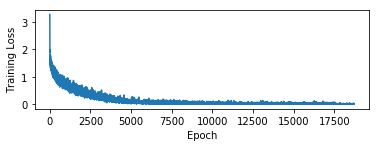

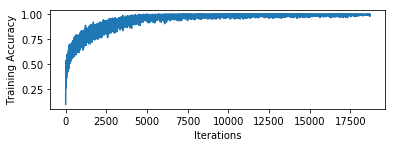

validation for epoch 48
-  epoch 48: validation accuracy = 0.777
train for epoch 49
iteration (18750): loss = 0.006, accuracy = 1.000
iteration (18800): loss = 0.005, accuracy = 1.000
iteration (18850): loss = 0.015, accuracy = 1.000
iteration (18900): loss = 0.002, accuracy = 1.000
iteration (18950): loss = 0.102, accuracy = 0.992
iteration (19000): loss = 0.016, accuracy = 0.992
iteration (19050): loss = 0.023, accuracy = 0.984


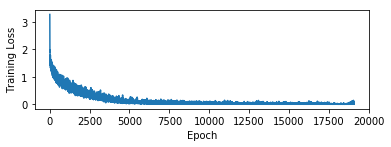

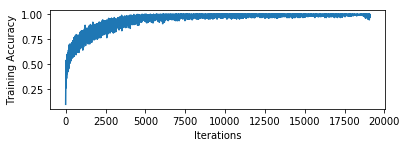

validation for epoch 49
-  epoch 49: validation accuracy = 0.785
train for epoch 50
iteration (19100): loss = 0.014, accuracy = 0.992
iteration (19150): loss = 0.003, accuracy = 1.000
iteration (19200): loss = 0.069, accuracy = 0.984
iteration (19250): loss = 0.019, accuracy = 0.984
iteration (19300): loss = 0.015, accuracy = 0.992
iteration (19350): loss = 0.009, accuracy = 1.000
iteration (19400): loss = 0.008, accuracy = 1.000
iteration (19450): loss = 0.023, accuracy = 0.992


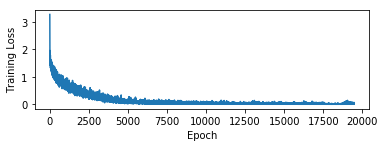

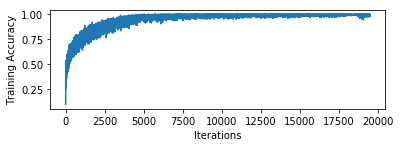

validation for epoch 50
-  epoch 50: validation accuracy = 0.788
train for epoch 51
iteration (19500): loss = 0.012, accuracy = 0.992
iteration (19550): loss = 0.004, accuracy = 1.000
iteration (19600): loss = 0.001, accuracy = 1.000
iteration (19650): loss = 0.002, accuracy = 1.000
iteration (19700): loss = 0.000, accuracy = 1.000
iteration (19750): loss = 0.004, accuracy = 1.000
iteration (19800): loss = 0.001, accuracy = 1.000
iteration (19850): loss = 0.010, accuracy = 0.992


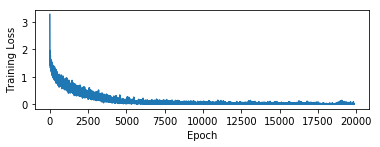

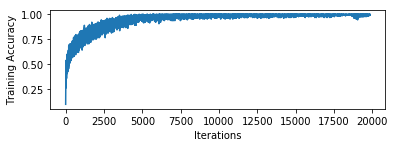

validation for epoch 51
-  epoch 51: validation accuracy = 0.782
train for epoch 52
iteration (19900): loss = 0.001, accuracy = 1.000
iteration (19950): loss = 0.001, accuracy = 1.000
iteration (20000): loss = 0.003, accuracy = 1.000
iteration (20050): loss = 0.003, accuracy = 1.000
iteration (20100): loss = 0.000, accuracy = 1.000
iteration (20150): loss = 0.002, accuracy = 1.000
iteration (20200): loss = 0.000, accuracy = 1.000


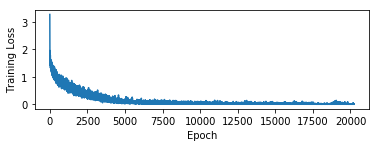

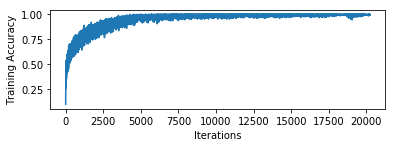

validation for epoch 52
-  epoch 52: validation accuracy = 0.785
train for epoch 53
iteration (20250): loss = 0.000, accuracy = 1.000
iteration (20300): loss = 0.001, accuracy = 1.000
iteration (20350): loss = 0.000, accuracy = 1.000
iteration (20400): loss = 0.001, accuracy = 1.000
iteration (20450): loss = 0.000, accuracy = 1.000
iteration (20500): loss = 0.000, accuracy = 1.000
iteration (20550): loss = 0.000, accuracy = 1.000
iteration (20600): loss = 0.000, accuracy = 1.000


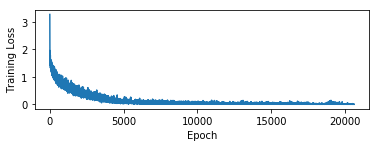

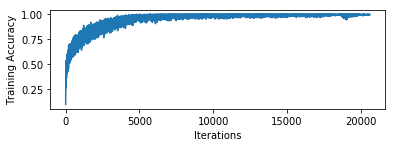

validation for epoch 53
-  epoch 53: validation accuracy = 0.779
train for epoch 54
iteration (20650): loss = 0.000, accuracy = 1.000
iteration (20700): loss = 0.004, accuracy = 1.000
iteration (20750): loss = 0.000, accuracy = 1.000
iteration (20800): loss = 0.000, accuracy = 1.000
iteration (20850): loss = 0.000, accuracy = 1.000
iteration (20900): loss = 0.000, accuracy = 1.000
iteration (20950): loss = 0.000, accuracy = 1.000
iteration (21000): loss = 0.000, accuracy = 1.000


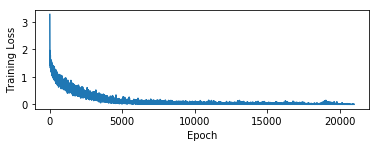

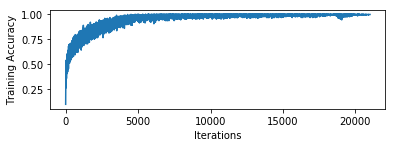

validation for epoch 54
-  epoch 54: validation accuracy = 0.792
train for epoch 55
iteration (21050): loss = 0.000, accuracy = 1.000
iteration (21100): loss = 0.000, accuracy = 1.000
iteration (21150): loss = 0.000, accuracy = 1.000
iteration (21200): loss = 0.000, accuracy = 1.000
iteration (21250): loss = 0.000, accuracy = 1.000
iteration (21300): loss = 0.016, accuracy = 0.992
iteration (21350): loss = 0.000, accuracy = 1.000


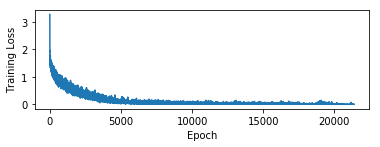

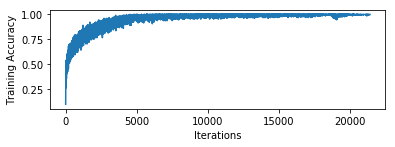

validation for epoch 55
-  epoch 55: validation accuracy = 0.789
train for epoch 56
iteration (21400): loss = 0.000, accuracy = 1.000
iteration (21450): loss = 0.007, accuracy = 0.992
iteration (21500): loss = 0.000, accuracy = 1.000
iteration (21550): loss = 0.000, accuracy = 1.000
iteration (21600): loss = 0.000, accuracy = 1.000
iteration (21650): loss = 0.000, accuracy = 1.000
iteration (21700): loss = 0.000, accuracy = 1.000
iteration (21750): loss = 0.000, accuracy = 1.000


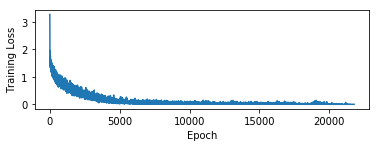

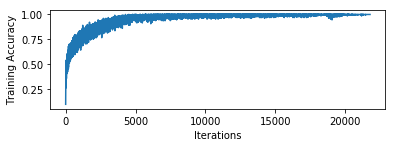

validation for epoch 56
-  epoch 56: validation accuracy = 0.792
train for epoch 57
iteration (21800): loss = 0.000, accuracy = 1.000
iteration (21850): loss = 0.000, accuracy = 1.000
iteration (21900): loss = 0.000, accuracy = 1.000
iteration (21950): loss = 0.000, accuracy = 1.000
iteration (22000): loss = 0.000, accuracy = 1.000
iteration (22050): loss = 0.000, accuracy = 1.000
iteration (22100): loss = 0.000, accuracy = 1.000
iteration (22150): loss = 0.000, accuracy = 1.000


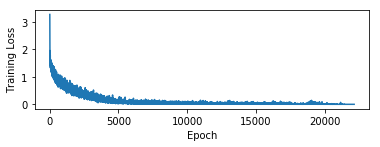

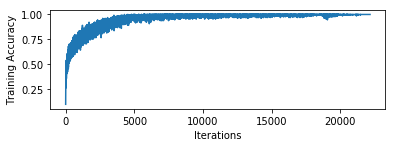

validation for epoch 57
-  epoch 57: validation accuracy = 0.794
train for epoch 58
iteration (22200): loss = 0.000, accuracy = 1.000
iteration (22250): loss = 0.000, accuracy = 1.000
iteration (22300): loss = 0.000, accuracy = 1.000
iteration (22350): loss = 0.000, accuracy = 1.000
iteration (22400): loss = 0.000, accuracy = 1.000
iteration (22450): loss = 0.000, accuracy = 1.000
iteration (22500): loss = 0.000, accuracy = 1.000


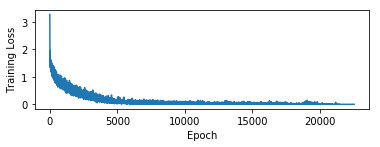

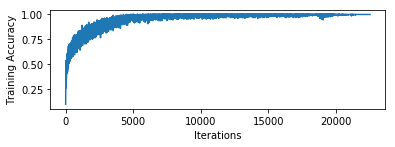

validation for epoch 58
-  epoch 58: validation accuracy = 0.792
train for epoch 59
iteration (22550): loss = 0.000, accuracy = 1.000
iteration (22600): loss = 0.000, accuracy = 1.000
iteration (22650): loss = 0.000, accuracy = 1.000
iteration (22700): loss = 0.000, accuracy = 1.000
iteration (22750): loss = 0.000, accuracy = 1.000
iteration (22800): loss = 0.000, accuracy = 1.000
iteration (22850): loss = 0.000, accuracy = 1.000
iteration (22900): loss = 0.000, accuracy = 1.000


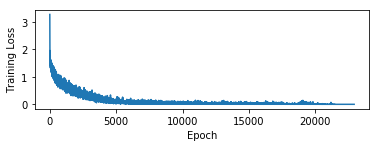

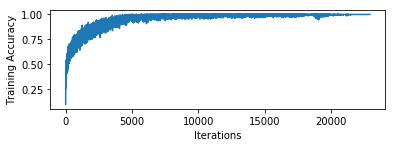

validation for epoch 59
-  epoch 59: validation accuracy = 0.791
***** test accuracy: 0.783
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [60]:
# Clear old computation graphs
tf.reset_default_graph()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    X_train = (X_train - np.mean(X_train,axis=0))/np.std(X_train, axis=0)
    X_val = (X_val - np.mean(X_train, axis=0))/np.std(X_train,axis=0)
    X_test = (X_test - np.mean(X_train,axis=0))/np.std(X_train, axis=0)

    train_data = data_augmentation(X_train,Y_train)
    X_train_ = train_data[0]
    Y_train_ = train_data[1]



    print (X_train_.shape, Y_train_.shape)

    


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################


    with tf.device('/gpu:0'):
        model = YourModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        # Save your model
    with tf.device('/cpu:0'):
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

In [61]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 128)
flat layer: (?, 2048)
fc4 layer: (?, 256)
fc5 layer: (?, 128)
fc6 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
